In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
import torch
import torchvision as tv
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Analysis of Raw Images

In [15]:
# Load the test set without applying normalization
test_set = CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Set batch size of x
test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False)

Files already downloaded and verified


## Mean and SD of Pixels
This calculates the average and deviation of the pixels in each image of the CIFAR-10 dataset.

In [8]:
# Iterate over the test set to compute the mean and standard deviation
mean = 0.
std = 0.
num_samples = 0.
for data, _ in test_loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    num_samples += batch_samples

mean /= num_samples
std /= num_samples

print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.4914, 0.4822, 0.4465])
Std: tensor([0.2023, 0.1994, 0.2010])


The standard deviation for each image is very small (~0.20), therefore it indicates that the pixel values are not very spread out and have relatively low variance.

# Analysis of Normalised Images
Applying our learnings from the analysis of raw images, we can now conclude that **a normalisation of mean by (0.4914, 0.4822, 0.4465) and std by (0.2023, 0.1994, 0.2010) is required** to bring the mean nearer to zero.

This normalizes the pixel values by subtracting 0.5 from each channel (shifting the range from [0, 1] to [-0.5, 0.5]) and dividing by 0.5 (scaling the range to [-1, 1]).

In [5]:
# Transform data into Tensor form (Torch.Tensor)
transform = transforms.Compose( [transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])])

# Load the test set and create a dataloader
test_set = CIFAR10(root='./data', train=True, download=True, transform=transform)

# Set batch size of x
test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False)

Files already downloaded and verified


In [6]:
# Iterate over the test set to compute the mean and standard deviation
mean = 0.
std = 0.
num_samples = 0.
for data, _ in test_loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    num_samples += batch_samples

mean /= num_samples
std /= num_samples

print("Mean:", mean)
print("Std:", std)

Mean: tensor([-1.5628e-06, -2.0851e-04,  1.5382e-04])
Std: tensor([1.0000, 1.0001, 0.9998])


The mean is close to 0. Therefore, the CNN model that we will train is not biased towards any pixel value range.

The standard deviation is similar (~1). Therefore, the CNN model that we will train will not be sensitive to variations in pixel values across images.

## Distribution of Labels
In the CIFAR-10 dataset we analyse, the labels are distributed relatively evenly.


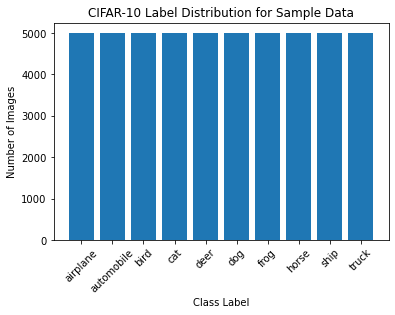

In [13]:
# Create a list of the class labels
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create a dictionary to count the number of images in each class
label_counts = {}
for i in range(10):
    label_counts[class_labels[i]] = 0
for lbl in lbls:
    label_counts[class_labels[lbl]] += 1

# Create a bar chart to visualize the label distribution
plt.bar(range(len(label_counts)), list(label_counts.values()), align='center')
plt.xticks(range(len(label_counts)), list(label_counts.keys()), rotation=45)
plt.title('CIFAR-10 Label Distribution for Sample Data')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.show()

## Sample of 10 Random Images
After normalisation, here is the visualisation of the first 10 images to explore image quality of the CIFAR-10 Dataset. The image is post-processed for better viewing.

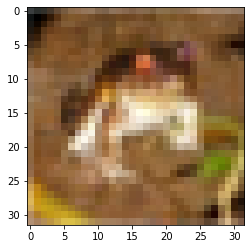

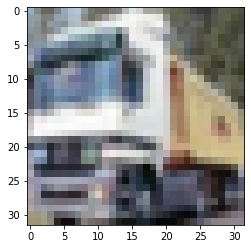

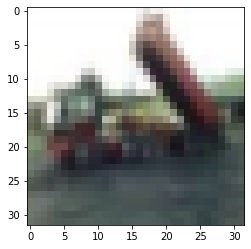

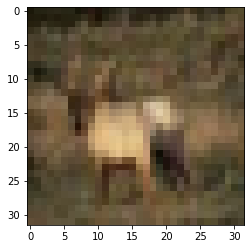

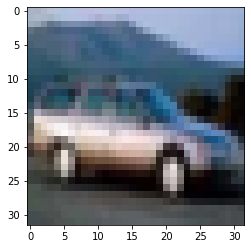

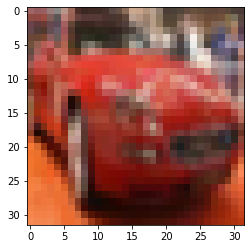

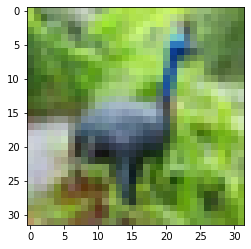

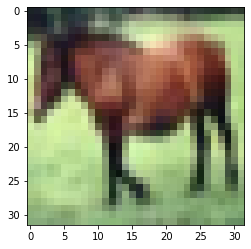

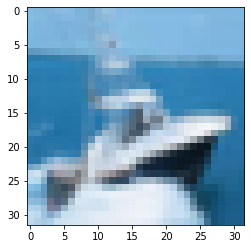

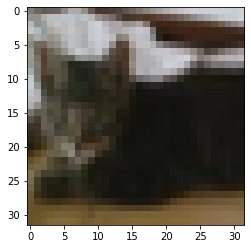

In [19]:
def display(img):
    # Post processing of image
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).reshape(3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).reshape(3, 1, 1)
    img = img * std + mean
    img = torch.clamp(img, 0.0, 1.0)  # clip the values to [0, 1] range
    
    # Convert into numpy array
    npimg = img.numpy()
    
    # Transpose as numpy needs h, w, c but pytorch uses c, h, w
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

# get first 100 training images
dataiter = iter(test_loader)
imgs, lbls = next(dataiter)

for i in range(10):
    display(tv.utils.make_grid(imgs[i]))

## Sample Image from Each Label
A preview of an image from each of the 10 labels - airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

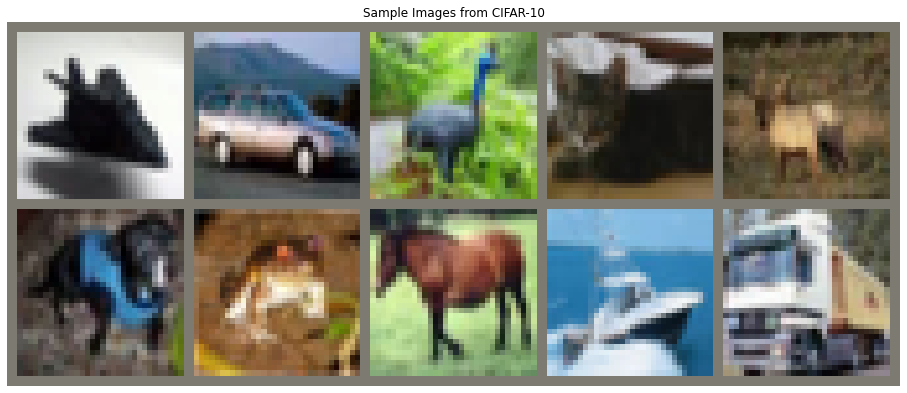

In [26]:
# Create a dictionary to store a sample image from each class
sample_images = {}
for i in range(10):
    for img, lbl in zip(imgs, lbls):
        # check if the label of the current image matches the current class label
        if lbl == i:
            # add the image to the dictionary of sample images for the current class label
            sample_images[lbl] = img
            break

# Create a grid of images to display the sample images
grid_image = tv.utils.make_grid(list(sample_images.values()), nrow=5)
npimg = grid_image.numpy()
plt.figure(figsize=(16,8))

# Post-process the normalized npimg
npimg = np.transpose(npimg, (1, 2, 0))
npimg = npimg * [0.2023, 0.1994, 0.2010] + [0.4914, 0.4822, 0.4465]
npimg = np.clip(npimg, 0, 1)

plt.imshow(npimg)
plt.axis('off')
plt.title('Sample Images from CIFAR-10')
plt.show()

## Color Distribution of CIFAR-10 Images
We plot the distribution of RGB values to ensure that the values are normalised to -1 and 1, and to check for biases in data. 


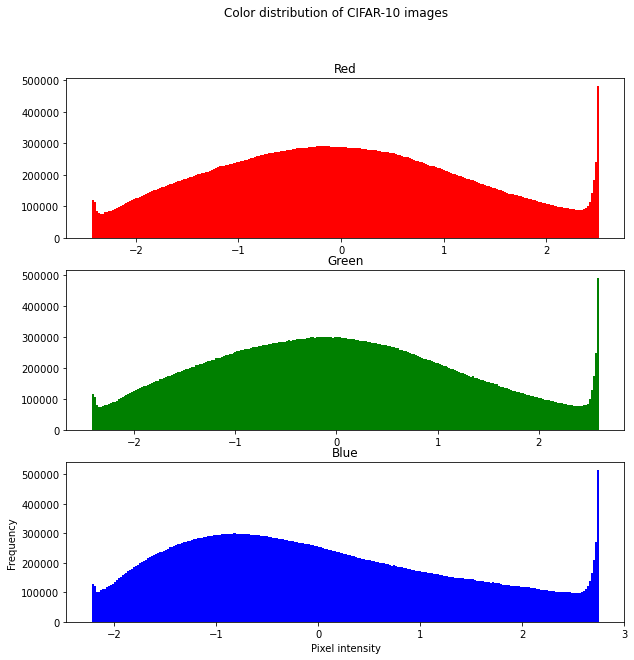

In [10]:
# Get the RGB pixel values of all images
r = []
g = []
b = []
for image, _ in test_set:
    r.append(image[0].numpy().ravel())
    g.append(image[1].numpy().ravel())
    b.append(image[2].numpy().ravel())

# Create a histogram for each color channel
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].hist(np.concatenate(r), bins=256, color='r')
axs[1].hist(np.concatenate(g), bins=256, color='g')
axs[2].hist(np.concatenate(b), bins=256, color='b')

# Set the title and axis labels
fig.suptitle('Color distribution of CIFAR-10 images')
axs[0].set_title('Red')
axs[1].set_title('Green')
axs[2].set_title('Blue')
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')
# Show the plot
plt.show()

The color distribution peaks around 0.0 for R and G, meaning that the values are centered around 0.0. As such, it indicates that Red and Green colors were effectively normalized in removing color biases for those two colors and minimising bias.

The color distribution peaks around -0.9 for B, meaning that the values are centered around -0.9. This could indicate that there is a bias towards lighter blue images in the dataset. This could be attributed to factors like lighting conditions of the images in the CIFAR-10 dataset.

**Outlier**: The graph peaks at the end as values that are bigger than 1 are normalised to 1.

## Pixel Intensity Distribution

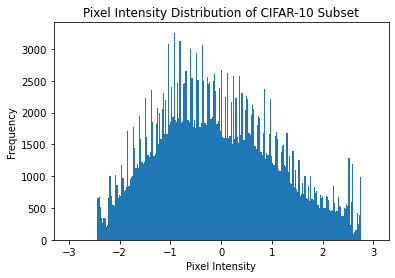

In [11]:
# Get random subset of 100 images
subset_indices = np.random.choice(len(test_set), size=100, replace=False)

# Concatenate image tensors into one array
subset_images = np.concatenate([test_set[i][0].numpy().ravel() for i in subset_indices])

# Plot intensity distribution
plt.hist(subset_images, bins=256, range=(-3, 3))
plt.title('Pixel Intensity Distribution of CIFAR-10 Subset')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

Pixel intensity is centered around -0.9 to 0. This suggests that the normalization is centered properly and the data is distributed evenly around the mean value.

## Principal Component Analysis (PCA) Plot
A plot that reduces the dimensionality of the data and analyses it to check for clusters/variation in features of our dataset.
The data is separated by its label in the CIFAR-10 dataset, from 0 to 9.

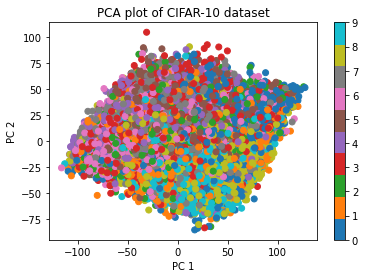

In [27]:
from sklearn.decomposition import PCA

# Extract data and labels
data = np.array([x.numpy().flatten() for x, _ in test_set])
labels = np.array([y for _, y in test_set])

# Perform PCA to reduce dimensionality to 2 dimensions
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

# Plot the results
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='tab10')
plt.colorbar()
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA plot of CIFAR-10 dataset')
plt.show()

We can see here that there are visible clusters by the labels. As such, the normalisation was effective in reducing the variation in the images and can help to improve the accuracy of our convolutionary neural network implementation.

## Summary of EDA
We started off by analysing the images' mean and standard deviation to get a gauge of the color distribution.
We also showed sample images to show how the images generally look - by random, as well as by labels.

Next, we applied this information to get necessary values for our normalisation, effectively normalising the mean and standard deviation to 0 and 1.

From here, we analysed the normalised data to ensure that it is well normalised for our CNN.
The color and pixel intensity distribution results show that the data is mostly well normalised, centering around 0.
At the same time, the PCA plot visualises the data, to show that there is low variation of images to better classify them.

As such, we will proceed with our image classification with this.